In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip

In [2]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
products.isnull().values.any()

False

In [4]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
aisles.isnull().values.any()

False

In [6]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
departments.isnull().values.any()

False

In [8]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

In [10]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
history.isnull().values.any()

False

In [12]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [44]:
per_aisle=products_litteral[['product_id', 'aisle']].groupby('aisle').count().sort_values(by='product_id', ascending=False)

<Figure size 2880x720 with 0 Axes>

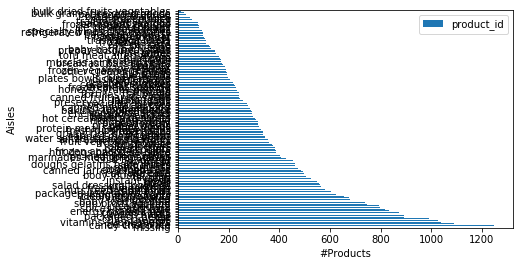

<Figure size 2880x720 with 0 Axes>

In [47]:
ax = per_aisle.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Aisles')

In [50]:
per_aisle.head()

,product_id
aisle,
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026


In [25]:
per_dpt=products_litteral[['product_id', 'department']].groupby('department').count().sort_values(by='product_id', ascending=False)

Text(0, 0.5, 'Departments')

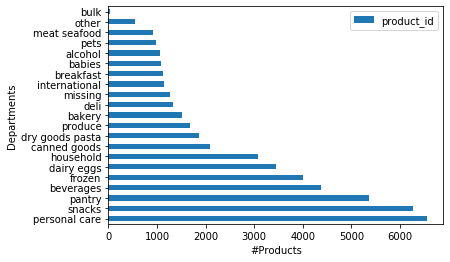

In [52]:
ax = per_dpt.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Departments')

In [26]:
per_dpt.sum()

product_id    49688
dtype: int64

In [22]:
products_litteral[products_litteral.department =='missing']

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing
...,...,...,...,...
44066,49553,Organic Plain Skyr,missing,missing
44067,49575,Chocolate Vanilla Malt Custard,missing,missing
44068,49641,"8\"" Pecan Pie",missing,missing
44069,49664,Lemon Cayenne Drinking Vinegar,missing,missing


1258 produits (sur 49688 soit 2%) ne sont pas catégorisés. Est ce qu'on les enlève ? Ou on utilise le dataset Amazon pour essayer de compléter ? Ou un autre ?
Ca a l'air assez bien réparti comme produits, assez random donc j'aurais tendance à dire de les laisser

In [1]:
!head -n 30 data/meta_Luxury_Beauty.json.gz

�?�]�meta_Luxury_Beauty.json �iw�Ʋ6���
lw��#����-��L�q7W�¼��%�27ǆ����6w�o;��3���uK��gn��n��l��s��#���-w���Vk��j7w7�io|�_Y&w�H�>wk9�k}
4��X�g���A=X7���+����:�Aw����*�+�����ֆ�~l�tcqK�[��G�B�[��U�m�p,n�`ŵ�<oŕ�L#���1mǧ��A��?���p�n�_�-��.T�6���\�&�[��!�'�ǳ�0Z����X���<+��m����5���;�5
������������Gl��r�9(	�՟��`�BU�[����h^�0��y�����݆h��t�T5И8b�D!�'�7Y�@u�6���Mw�@�
LG(L��l�tL���1��7�ϳ�wx-���k^��T���%C���&���8ؕ��W�� zgA4�)�
�M|���Q2��?�6֝�h�y	��b��]�����;���%XH;�΁kf�uyGjF/	b�"�0<��o��
���<�>�n��*�5/2��uw�	�/-Y�P�Щ̓�۾O:U�\9�@�`��U}�@/J����exwJ2�5,k�ޏ˃��J}����Gm���h�Q,K��y��t�᭗}�a;p,x+�{���"5������5]�hE�w�uxƉ
�A��\g�#l:�{q��#��<�W�����ۉ���R��U�o}U�M
��?S�ܬD�i�r��oM�or���4����^T��Y!��*��|K	�5:��.�wjb[l	]5�&T�rEl����rM�A�Kr�}+u+b�^�߄VOn��%�Mo5��4jg��mV���Io<��5����9I���u�΂><�:᷼1<W�"��)�/����)_��2K�N�Њ�Y��󬾪:�M��6�u��H���Pd}������>�g�n�芽&C�
�������1���̵����B�^�P� g���7�f�b0Q���TU.
7z��0OZ�}��u�c{��O�m�O

In [89]:
meta_luxe = pd.read_json('data/meta_Luxury_Beauty.json.gz', compression='gzip', lines=True)
meta_luxe.head()

,description,title,also_buy,image,rank,also_view,details,main_cat,price,asin,brand,feature
0,[After a long day of handling thorny situation...,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,"4,324inBeautyPersonalCare(","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...","\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,$30.00,B00004U9V2,NaN,NaN
1,[If you haven't experienced the pleasures of b...,AHAVA Bath Salts,NaN,NaN,"1,633,549inBeautyPersonalCare(",NaN,"\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,NaN,B0000531EN,NaN,NaN
2,"[Rich, black mineral mud, harvested from the b...","AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",NaN,[https://images-na.ssl-images-amazon.com/image...,"1,806,710inBeautyamp;PersonalCare(",NaN,"\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,NaN,B0000532JH,NaN,NaN
3,[This liquid soap with convenient pump dispens...,"Crabtree & Evelyn Hand Soap, Gardeners, 10.1 f...",NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,"[B00004U9V2, B00GHX7H0A, B00FRERO7G, B00R68QXC...","\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,$15.99,B00005A77F,NaN,NaN
4,[Remember why you love your favorite blanket? ...,Soy Milk Hand Crme,"[B000NZT6KM, B001BY229Q, B008J724QY, B0009YGKJ...",[https://images-na.ssl-images-amazon.com/image...,"42,464inBeautyamp;PersonalCare(",NaN,"\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,$18.00,B00005NDTD,NaN,NaN


In [8]:
luxe = pd.read_json('data/Luxury_Beauty.json.gz', compression='gzip', lines=True)
luxe.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN
